# Logistic Regression

## The data

我们将建立一个逻辑回归模型来预测一个学生是否被大学录取。假设你是一个大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会。你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集。对于每一个培训例子，你有两个考试的申请人的分数和录取决定。为了做到这一点，我们将建立一个分类模型，根据考试成绩估计入学概率。

In [1]:
# 三大件 # 可以直接在你的python console里面生成图像。不需要plt.show()就可进行展示
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import os
path = 'data' + os.sep + 'LogiReg_data.txt'  # 为了让代码在不同的平台上都能运行，路径应该写'\'还是'/'无所谓。
pdData = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])  # header = None自己制定列名
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
pdData.shape # 看数据的维度。

(100, 3)

Text(0,0.5,'Exam 2 Score')

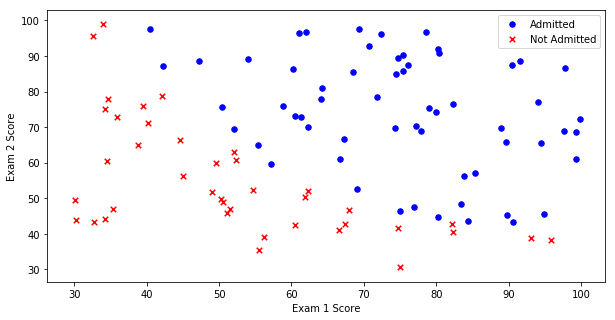

In [4]:
positive = pdData[pdData['Admitted'] == 1] # returns the subset of rows such Admitted = 1, i.e. the set of *positive* examples
negative = pdData[pdData['Admitted'] == 0] # returns the subset of rows such Admitted = 0, i.e. the set of *negative* examples

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()  #  legend（）有一个loc参数，用于控制图例的位置。 比如 plot.legend(loc=2) , 这个位置就是4象项中的第二象项，也就是左上角。 loc可以为1,2,3,4 这四个数字。
            # 如果把那句legend() 的语句去掉，那么图形上的图例也就会消失了。
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

## The logistic regression

目标：建立分类器--即决策边界（求解出三个参数 $\theta_0         \theta_1         \theta_2 $）


设定**阈值**，根据阈值判断录取结果--就是分类的概率判断，一般为 0.5

### 要完成的模块
-  `sigmoid` : 映射到概率的函数

-  `model` : 返回预测结果值

-  `cost` : 根据参数计算损失

-  `gradient` : 计算每个参数的梯度方向

-  `descent` : 进行参数更新

-  `accuracy`: 计算精度

###  `sigmoid` 函数

$$
g(z) = \frac{1}{1+e^{-z}}   
$$

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))  # np.exp(-z)表示e的多少次幂

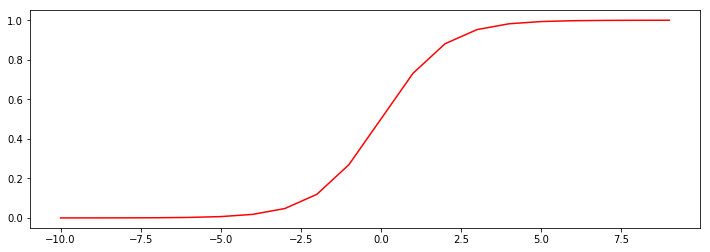

In [6]:
nums = np.arange(-10, 10, step=1) #creates a vector containing 20 equally spaced values from -10 to 10
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(nums, sigmoid(nums), 'r')

### Sigmoid
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$

### `model` **完成预测函数 $h_\theta(x)$**

In [7]:
def model(X, theta):
    
    return sigmoid(np.dot(X, theta.T))  # np.dot是矩阵的乘法,也可以用 @

$$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\
x_{1}\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$

In [8]:

pdData.insert(0, 'Ones', 1) # 插入零的一列，列指标为 Ones

# set X (training data) and y (target variable)
orig_data = pdData.as_matrix() # 习惯性的操作。很多时候取得的数据是DataFrame的形式(直接转换csv格式的数据以后)，这个时候要记得转换成数组
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
#X = np.matrix(X.values)
#y = np.matrix(data.iloc[:,3:4].values) #np.array(y.values)
theta = np.zeros([1, 3])  # 参数theta 一般先构造出来，用zero来占位，构造1行3列的数据。即三个theta参数

**来看看数据的样子吧**

In [9]:
X[:5]  # 前 5 行的数据

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [10]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [11]:
theta

array([[0., 0., 0.]])

In [12]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

### 损失函数（代价函数）
将对数似然函数去负号

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{m}\sum_{i=1}^{m} D(h_\theta(x_i), y_i)
$$

In [13]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))  # np.multiply对数据完成的乘的操作
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))   # np.sum完成对数据的加和

In [14]:
cost(X, y, theta)

0.6931471805599453

### 计算梯度 -- 最难的部分


$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$


In [15]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)  # 梯度计算需要考虑 theta 的个数（维度）
    error = (model(X, theta)- y).ravel()  # 把负号提取到里面了，revel()将数据降为1维！不会产生原数据的副本
    for j in range(len(theta.ravel())):   # theta降低为 1 维度，这样就可以求theta的个数了，进行遍历
        term = np.multiply(error, X[:,j]) # 矩阵的乘法，取第j列。
        grad[0, j] = np.sum(term) / len(X) # 每一个梯度j算一个值。取[0, j]
    
    return grad

### Gradient descent

比较3中不同梯度下降方法--**批量、随机、小批量**


In [16]:
STOP_ITER = 0  # 根据迭代次数停止
STOP_COST = 1  # 根据损失值的变化停止
STOP_GRAD = 2  # 根据梯度的变化（很小）停止

def stopCriterion(type, value, threshold):
    """设定三种不同的停止策略"""
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:      return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      return np.linalg.norm(value) < threshold

In [17]:
import numpy.random
#洗牌
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

In [18]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    #梯度下降求解
    
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值

    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            X, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

In [19]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

### 不同的停止策略

#### 设定迭代次数

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.84s


array([[-0.00027127,  0.00705232,  0.00376711]])

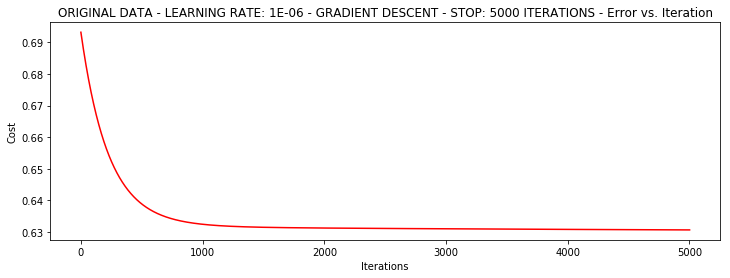

In [20]:
#选择的梯度下降方法是基于所有样本的
n=100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

#### 根据损失值停止

设定阈值 1E-6, 差不多需要110 000次迭代 

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 17.39s


array([[-5.13364014,  0.04771429,  0.04072397]])

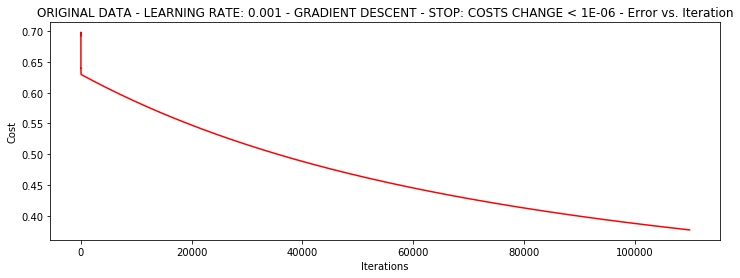

In [21]:
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

#### 根据梯度变化停止

设定阈值 0.05,差不多需要40 000次迭代

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 6.61s


array([[-2.37033409,  0.02721692,  0.01899456]])

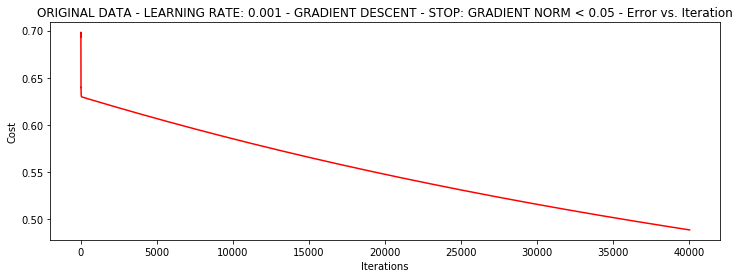

In [22]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

### 对比不同的梯度下降方法

#### Stochastic descent

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.38467773 -0.01557218 -0.00588611]] - Iter: 5000 - Last cost: 1.35 - Duration: 0.24s


array([[-0.38467773, -0.01557218, -0.00588611]])

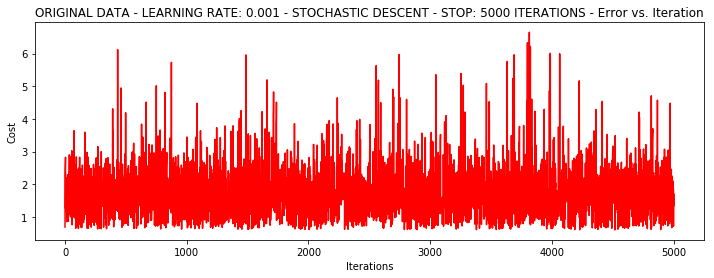

In [23]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

有点爆炸。。。很不稳定,再来试试把学习率调小一些

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.00202325  0.00993787  0.00083336]] - Iter: 15000 - Last cost: 0.63 - Duration: 0.74s


array([[-0.00202325,  0.00993787,  0.00083336]])

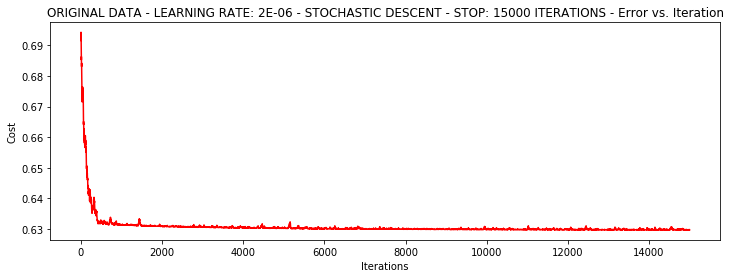

In [24]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

速度快，但稳定性差，需要很小的学习率

#### Mini-batch descent

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[-1.0339814   0.03279438  0.02620843]] - Iter: 15000 - Last cost: 0.92 - Duration: 1.00s


array([[-1.0339814 ,  0.03279438,  0.02620843]])

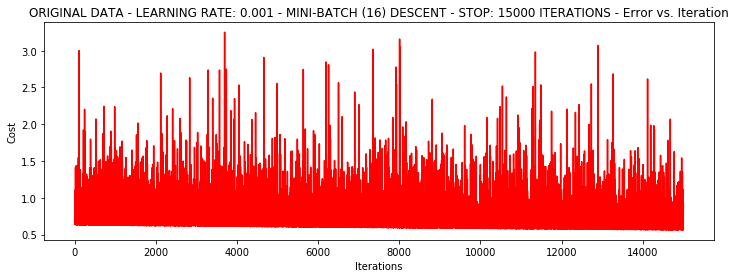

In [25]:
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

浮动仍然比较大，我们来尝试下对数据进行标准化
将数据按其属性(按列进行)减去其均值，然后除以其方差。最后得到的结果是，对每个属性/每列来说所有数据都聚集在0附近，方差值为1

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[0.3080807  0.86494967 0.77367651]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.85s


array([[0.3080807 , 0.86494967, 0.77367651]])

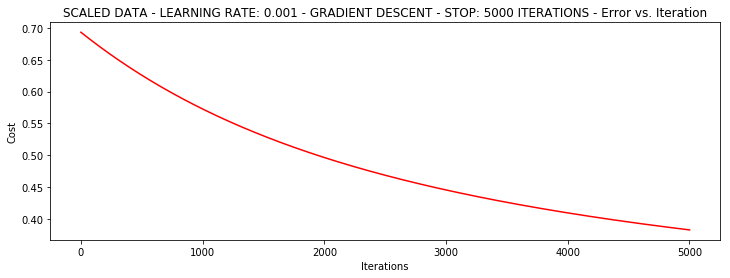

In [26]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])

runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

它好多了！原始数据，只能达到达到0.61，而我们得到了0.38个在这里！
所以对数据做预处理是非常重要的

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.02
Theta: [[1.0707921  2.63030842 2.41079787]] - Iter: 59422 - Last cost: 0.22 - Duration: 10.38s


array([[1.0707921 , 2.63030842, 2.41079787]])

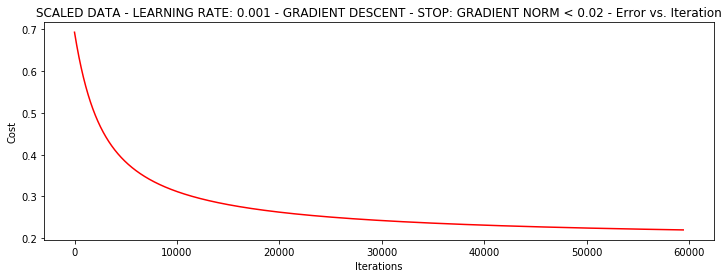

In [27]:
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

更多的迭代次数会使得损失下降的更多！

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[1.1482069  2.79436539 2.566394  ]] - Iter: 72674 - Last cost: 0.22 - Duration: 4.35s


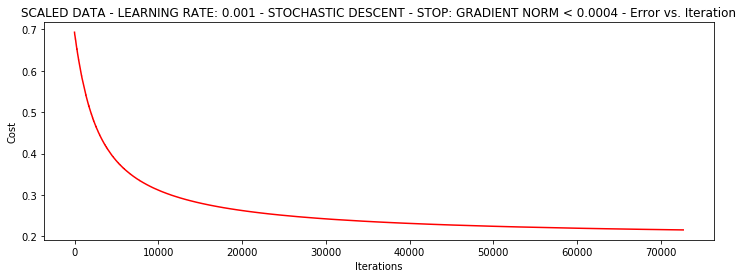

In [28]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)

随机梯度下降更快，但是我们需要迭代的次数也需要更多，所以还是用batch的比较合适！！！

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.004
Theta: [[1.15463805 2.80561472 2.57843833]] - Iter: 1083 - Last cost: 0.22 - Duration: 0.08s


array([[1.15463805, 2.80561472, 2.57843833]])

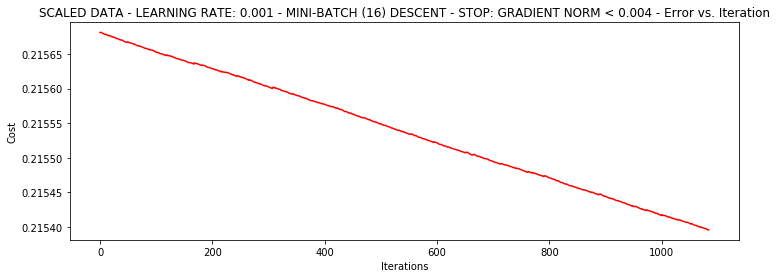

In [29]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)

## 精度

In [30]:
#设定阈值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [31]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%


## 逻辑回归到这里就结束了！